In [1]:
# Cell 1: Install Required Packages
!pip install folium geopandas plotly mapclassify branca ipywidgets -q

print("✅ Mapping and visualization packages installed successfully!")

✅ Mapping and visualization packages installed successfully!



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, MiniMap, Fullscreen
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import branca.colormap as cm
from datetime import datetime, timedelta
import joblib
import os
from IPython.display import display, HTML

print("✅ All mapping and visualization libraries imported successfully!")

✅ All mapping and visualization libraries imported successfully!


In [3]:
# Cell 3: Configuration
# Map Configuration
CITY_COORDINATES = [18.5204, 73.8567]  # Pune, India
MAP_ZOOM = 11
HEATMAP_RADIUS = 20
HEATMAP_BLUR = 15

# Pollution Source Colors and Icons
POLLUTION_SOURCE_CONFIG = {
    'Industrial': {'color': 'red', 'icon': 'industry', 'marker_color': 'red'},
    'Traffic': {'color': 'orange', 'icon': 'car', 'marker_color': 'orange'},
    'Commercial': {'color': 'green', 'icon': 'shopping-cart', 'marker_color': 'green'},
    'Residential': {'color': 'blue', 'icon': 'home', 'marker_color': 'blue'},
    'Background': {'color': 'gray', 'icon': 'cloud', 'marker_color': 'gray'}
}

# Pollution Thresholds (WHO Guidelines)
POLLUTION_THRESHOLDS = {
    'PM2.5': {'good': 12, 'moderate': 35, 'unhealthy': 55, 'hazardous': 150},
    'PM10': {'good': 54, 'moderate': 154, 'unhealthy': 254, 'hazardous': 424},
    'NO2': {'good': 40, 'moderate': 100, 'unhealthy': 360, 'hazardous': 649}
}

print("🗺️ MAPPING CONFIGURATION")
print(f"📍 City Center: {CITY_COORDINATES}")
print(f"🎯 Zoom Level: {MAP_ZOOM}")
print(f"🌫️ Pollution Sources: {list(POLLUTION_SOURCE_CONFIG.keys())}")

🗺️ MAPPING CONFIGURATION
📍 City Center: [18.5204, 73.8567]
🎯 Zoom Level: 11
🌫️ Pollution Sources: ['Industrial', 'Traffic', 'Commercial', 'Residential', 'Background']


In [4]:
# Cell 4: Load Data and Models
print("📥 LOADING DATA AND MODELS...")

try:
    # Load the comprehensive dataset
    df = pd.read_csv('../data/pollution_data_comprehensive.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"✅ Data loaded: {df.shape[0]:,} records, {df.shape[1]} columns")
    
    # Load trained models
    model_artifacts = joblib.load('../models/pollution_source_model_artifacts.joblib')
    print("✅ Models loaded successfully")
    
    # Load preprocessing artifacts
    preprocessing = joblib.load('../models/preprocessing_artifacts.joblib')
    print("✅ Preprocessing artifacts loaded")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please run Module 1 and Module 2 first!")
    raise

# Display basic data info
print(f"\n📊 DATA OVERVIEW:")
print(f"• Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"• Sensors: {df['sensor_name'].nunique()}")
print(f"• Area types: {df['area_type'].unique().tolist()}")

# Show first few rows
print(f"\n🔍 SAMPLE DATA:")
display(df.head(3))

📥 LOADING DATA AND MODELS...
✅ Data loaded: 5,768 records, 31 columns
✅ Models loaded successfully
✅ Preprocessing artifacts loaded

📊 DATA OVERVIEW:
• Date range: 2025-09-30 10:08:36.680470 to 2025-10-30 10:08:36.680470
• Sensors: 8
• Area types: ['urban', 'industrial', 'residential', 'commercial', 'suburban']

🔍 SAMPLE DATA:


,timestamp,sensor_id,sensor_name,sensor_latitude,sensor_longitude,area_type,PM2.5,PM10,NO2,SO2,...,industrial_area,commercial_area,residential_area,green_space,building_density,hour,day_of_week,month,is_weekend,is_rush_hour
0,2025-09-30 10:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,37.85,54.45,25.34,15.30,...,5,25,36,68,10774,10,1,9,0,0
1,2025-09-30 11:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,31.44,72.31,17.07,11.19,...,5,25,36,68,10774,11,1,9,0,0
2,2025-09-30 12:08:36.680470,sensor_00,Pune_City_Center,18.5204,73.8567,urban,29.30,66.53,19.39,6.24,...,5,25,36,68,10774,12,1,9,0,0


In [5]:
# Cell 5: Data Preparation for Mapping
print("📋 PREPARING DATA FOR MAPPING...")

# Create a recent data subset (last 7 days for better visualization)
recent_cutoff = df['timestamp'].max() - timedelta(days=7)
recent_data = df[df['timestamp'] >= recent_cutoff].copy()

print(f"✅ Using recent data: {recent_data.shape[0]:,} records from last 7 days")

# Calculate average pollution levels by sensor
sensor_aggregated = recent_data.groupby('sensor_name').agg({
    'sensor_latitude': 'first',
    'sensor_longitude': 'first',
    'area_type': 'first',
    'PM2.5': ['mean', 'max', 'std'],
    'PM10': 'mean',
    'NO2': 'mean',
    'temperature_c': 'mean',
    'wind_speed_ms': 'mean'
}).round(2)

# Flatten column names
sensor_aggregated.columns = ['_'.join(col).strip() for col in sensor_aggregated.columns.values]
sensor_aggregated = sensor_aggregated.reset_index()

# Rename columns for easier access
sensor_aggregated.columns = [
    'sensor_name', 'latitude', 'longitude', 'area_type',
    'pm25_mean', 'pm25_max', 'pm25_std', 'pm10_mean', 'no2_mean',
    'temp_mean', 'wind_mean'
]

print(f"✅ Sensor data aggregated: {len(sensor_aggregated)} sensors")

# Add pollution risk categories
def get_pollution_risk(pm25):
    if pm25 <= POLLUTION_THRESHOLDS['PM2.5']['good']:
        return 'Good', 'green'
    elif pm25 <= POLLUTION_THRESHOLDS['PM2.5']['moderate']:
        return 'Moderate', 'yellow'
    elif pm25 <= POLLUTION_THRESHOLDS['PM2.5']['unhealthy']:
        return 'Unhealthy', 'orange'
    else:
        return 'Hazardous', 'red'

sensor_aggregated[['risk_level', 'risk_color']] = sensor_aggregated['pm25_mean'].apply(
    lambda x: pd.Series(get_pollution_risk(x))
)

print("✅ Pollution risk levels calculated")
display(sensor_aggregated.head(3))

📋 PREPARING DATA FOR MAPPING...
✅ Using recent data: 1,352 records from last 7 days
✅ Sensor data aggregated: 8 sensors
✅ Pollution risk levels calculated


,sensor_name,latitude,longitude,area_type,pm25_mean,pm25_max,pm25_std,pm10_mean,no2_mean,temp_mean,wind_mean,risk_level,risk_color
0,Aundh_Residential,18.56,73.81,residential,28.19,50.43,7.83,45.69,17.96,24.0,2.9,Moderate,yellow
1,Hadapsar_Industrial,18.50,73.94,industrial,63.15,110.49,17.26,102.49,46.98,24.0,2.6,Hazardous,red
2,Hinjewadi_Industrial,18.59,73.74,industrial,58.64,102.22,16.48,102.68,45.88,23.9,3.0,Hazardous,red


In [6]:
import folium
from folium.plugins import MiniMap, Fullscreen, MeasureControl

print("🗺️ CREATING BASE INTERACTIVE MAP...")

def create_base_map():
    """Create a base Folium map with multiple tile layers"""
    
    # Create base map
    m = folium.Map(
        location=CITY_COORDINATES,
        zoom_start=MAP_ZOOM,
        tiles='OpenStreetMap',
        control_scale=True,
        prefer_canvas=True
    )

    # ✅ Official tile providers (exact URLs + attribution)
    tile_layers = {
        'OpenStreetMap': ('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
                          '© OpenStreetMap contributors'),
        'CartoDB Positron': ('https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png',
                             '© OpenStreetMap contributors © CARTO'),
        'CartoDB Dark Matter': ('https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',
                                '© OpenStreetMap contributors © CARTO'),
        'Stamen Terrain': ('https://stamen-tiles.a.ssl.fastly.net/terrain/{z}/{x}/{y}.jpg',
                           'Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors'),
        'Stamen Toner': ('https://stamen-tiles.a.ssl.fastly.net/toner/{z}/{x}/{y}.png',
                         'Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors')
    }

    # Add each tile layer with proper attribution
    for name, (url, attr) in tile_layers.items():
        folium.TileLayer(tiles=url, name=name, attr=attr).add_to(m)

    # Add map controls
    folium.LayerControl().add_to(m)
    Fullscreen().add_to(m)
    MiniMap().add_to(m)
    MeasureControl().add_to(m)
    
    print("✅ Base map created successfully with multiple layers!")
    return m

# Create the base map
base_map = create_base_map()


🗺️ CREATING BASE INTERACTIVE MAP...
✅ Base map created successfully with multiple layers!


In [7]:
# Cell 7: Create Sensor Markers Map
print("📍 CREATING SENSOR MARKERS MAP...")

def create_sensor_markers_map():
    """Create map with detailed sensor markers"""
    
    m = create_base_map()
    
    # Create feature groups for different risk levels
    risk_groups = {
        'Good': folium.FeatureGroup(name='✅ Good Air Quality', show=True),
        'Moderate': folium.FeatureGroup(name='⚠️ Moderate Air Quality', show=True),
        'Unhealthy': folium.FeatureGroup(name='🚨 Unhealthy Air Quality', show=True),
        'Hazardous': folium.FeatureGroup(name='💀 Hazardous Air Quality', show=True)
    }
    
    # Add sensors to the map
    for _, sensor in sensor_aggregated.iterrows():
        # Create popup content
        popup_content = f"""
        <div style="width: 280px;">
            <h4>📍 {sensor['sensor_name']}</h4>
            <div style="background-color: {sensor['risk_color']}; padding: 5px; border-radius: 5px; color: white; font-weight: bold;">
                Air Quality: {sensor['risk_level']}
            </div>
            <hr>
            <b>Pollution Levels:</b><br>
            • PM2.5: {sensor['pm25_mean']} μg/m³ (avg)<br>
            • PM2.5: {sensor['pm25_max']} μg/m³ (max)<br>
            • PM10: {sensor['pm10_mean']} μg/m³<br>
            • NO2: {sensor['no2_mean']} μg/m³<br>
            <hr>
            <b>Weather:</b><br>
            • Temperature: {sensor['temp_mean']}°C<br>
            • Wind Speed: {sensor['wind_mean']} m/s<br>
            <hr>
            <b>Area Type:</b> {sensor['area_type']}<br>
            <small>Last updated: {recent_data['timestamp'].max().strftime('%Y-%m-%d %H:%M')}</small>
        </div>
        """
        
        # Determine icon based on area type
        area_icons = {
            'industrial': 'industry',
            'commercial': 'shopping-cart',
            'residential': 'home',
            'urban': 'building',
            'suburban': 'home'
        }
        
        icon_name = area_icons.get(sensor['area_type'], 'info-circle')
        
        # Create marker
        marker = folium.Marker(
            location=[sensor['latitude'], sensor['longitude']],
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=f"{sensor['sensor_name']} - {sensor['risk_level']}",
            icon=folium.Icon(
                color=sensor['risk_color'],
                icon=icon_name,
                prefix='fa'
            )
        )
        
        # Add to appropriate risk group
        risk_groups[sensor['risk_level']].add_child(marker)
    
    # Add all feature groups to map
    for group in risk_groups.values():
        group.add_to(m)
    
    # Add title
    title_html = '''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>🌍 AI-EnviroScan: Pollution Sensor Network</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    print("✅ Sensor markers map created")
    return m

sensor_map = create_sensor_markers_map()

📍 CREATING SENSOR MARKERS MAP...
✅ Base map created successfully with multiple layers!
✅ Sensor markers map created


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12692\3953765368.py:58: UserWarning: color argument of Icon should be one of: {'darkblue', 'black', 'darkgreen', 'red', 'purple', 'cadetblue', 'lightred', 'pink', 'green', 'blue', 'white', 'beige', 'lightblue', 'darkred', 'gray', 'lightgreen', 'orange', 'lightgray', 'darkpurple'}.
  icon=folium.Icon(


In [8]:
# Cell 8: Create Pollution Heatmap
print("🔥 CREATING POLLUTION HEATMAP...")

def create_pollution_heatmap(pollutant='PM2.5'):
    """Create heatmap for specific pollutant"""
    
    m = create_base_map()
    
    # Prepare heatmap data
    heat_data = []
    for _, row in recent_data.iterrows():
        value = row[pollutant]
        # Normalize value for better visualization
        normalized_value = min(value / 100, 1.0)
        heat_data.append([row['sensor_latitude'], row['sensor_longitude'], normalized_value])
    
    # Create gradient based on pollutant
    if pollutant == 'PM2.5':
        gradient = {0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
    elif pollutant == 'PM10':
        gradient = {0.2: 'blue', 0.4: 'green', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
    else:  # NO2
        gradient = {0.2: 'blue', 0.4: 'purple', 0.6: 'orange', 0.8: 'red', 1.0: 'darkred'}
    
    # Add heatmap layer
    HeatMap(
        heat_data,
        radius=HEATMAP_RADIUS,
        blur=HEATMAP_BLUR,
        max_zoom=13,
        gradient=gradient,
        name=f'{pollutant} Heatmap'
    ).add_to(m)
    
    # Add title
    title_html = f'''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>🔥 {pollutant} Pollution Heatmap - Pune</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    print(f"✅ {pollutant} heatmap created")
    return m

# Create heatmaps for different pollutants
pm25_heatmap = create_pollution_heatmap('PM2.5')
pm10_heatmap = create_pollution_heatmap('PM10')
no2_heatmap = create_pollution_heatmap('NO2')

🔥 CREATING POLLUTION HEATMAP...
✅ Base map created successfully with multiple layers!
✅ PM2.5 heatmap created
✅ Base map created successfully with multiple layers!
✅ PM10 heatmap created
✅ Base map created successfully with multiple layers!
✅ NO2 heatmap created


In [9]:
# Cell 9: Create Risk Zone Map
print("⚠️ CREATING RISK ZONE MAP...")

def create_risk_zone_map():
    """Create map with colored risk zones"""
    
    m = create_base_map()
    
    # Create colormap for PM2.5 levels
    colormap = cm.LinearColormap(
        colors=['green', 'yellow', 'orange', 'red', 'darkred'],
        vmin=0,
        vmax=150,  # PM2.5 scale
        caption='PM2.5 Concentration (μg/m³)'
    )
    
    # Add risk zones (circles) for each sensor
    for _, sensor in sensor_aggregated.iterrows():
        # Calculate circle radius based on pollution level
        radius = min(800, max(100, sensor['pm25_mean'] * 8))
        
        # Create circle for risk zone
        folium.Circle(
            location=[sensor['latitude'], sensor['longitude']],
            radius=radius,
            popup=f"""
            <b>{sensor['sensor_name']}</b><br>
            Risk: {sensor['risk_level']}<br>
            PM2.5: {sensor['pm25_mean']} μg/m³<br>
            Area: {sensor['area_type']}
            """,
            color=sensor['risk_color'],
            fill=True,
            fillOpacity=0.4,
            weight=2,
            fillColor=sensor['risk_color']
        ).add_to(m)
        
        # Add marker in center
        folium.Marker(
            location=[sensor['latitude'], sensor['longitude']],
            popup=sensor['sensor_name'],
            icon=folium.Icon(color=sensor['risk_color'], icon='info-sign')
        ).add_to(m)
    
    # Add colormap to map
    colormap.add_to(m)
    
    # Add title
    title_html = '''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>⚠️ Pollution Risk Zones - Pune</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    print("✅ Risk zone map created")
    return m

risk_zone_map = create_risk_zone_map()

⚠️ CREATING RISK ZONE MAP...
✅ Base map created successfully with multiple layers!
✅ Risk zone map created


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12692\1714831364.py:43: UserWarning: color argument of Icon should be one of: {'darkblue', 'black', 'darkgreen', 'red', 'purple', 'cadetblue', 'lightred', 'pink', 'green', 'blue', 'white', 'beige', 'lightblue', 'darkred', 'gray', 'lightgreen', 'orange', 'lightgray', 'darkpurple'}.
  icon=folium.Icon(color=sensor['risk_color'], icon='info-sign')


In [10]:
# Cell 10: Create Time Animation Map
print("⏰ CREATING TIME ANIMATION MAP...")

def create_time_animation_map():
    """Create map showing pollution changes over time"""
    
    m = create_base_map()
    
    # Group data by hour for animation
    recent_data['hour'] = recent_data['timestamp'].dt.hour
    hourly_data = recent_data.groupby(['sensor_name', 'hour']).agg({
        'sensor_latitude': 'first',
        'sensor_longitude': 'first',
        'PM2.5': 'mean'
    }).reset_index()
    
    # Create feature group for each hour
    for hour in sorted(hourly_data['hour'].unique()):
        hour_data = hourly_data[hourly_data['hour'] == hour]
        
        feature_group = folium.FeatureGroup(name=f'🕐 {hour:02d}:00', show=False)
        
        for _, row in hour_data.iterrows():
            # Create circle marker with size based on PM2.5
            radius = min(500, max(50, row['PM2.5'] * 4))
            
            folium.CircleMarker(
                location=[row['sensor_latitude'], row['sensor_longitude']],
                radius=radius / 50,  # Scale for better visualization
                popup=f"Hour: {hour}:00 | PM2.5: {row['PM2.5']:.1f} μg/m³",
                color='red',
                fill=True,
                fillOpacity=0.6,
                weight=1
            ).add_to(feature_group)
        
        feature_group.add_to(m)
    
    # Add title
    title_html = '''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>⏰ Pollution Patterns by Hour</b>
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    print("✅ Time animation map created")
    return m

time_animation_map = create_time_animation_map()

⏰ CREATING TIME ANIMATION MAP...
✅ Base map created successfully with multiple layers!
✅ Time animation map created


In [11]:
# Cell 11: Create Comprehensive Dashboard Map
print("📊 CREATING COMPREHENSIVE DASHBOARD MAP...")

def create_comprehensive_dashboard_map():
    """Create a comprehensive map with all visualization layers"""
    
    m = create_base_map()
    
    # Layer 1: Heatmap (base layer)
    heat_data = [[row['sensor_latitude'], row['sensor_longitude'], row['PM2.5']] 
                 for _, row in recent_data.iterrows()]
    
    HeatMap(
        heat_data,
        radius=HEATMAP_RADIUS,
        blur=HEATMAP_BLUR,
        max_zoom=13,
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'},
        name='PM2.5 Heatmap',
        show=False
    ).add_to(m)
    
    # Layer 2: Sensor markers
    marker_cluster = MarkerCluster(name='Sensor Locations', show=True)
    for _, sensor in sensor_aggregated.iterrows():
        popup_content = f"""
        <div style="width: 250px;">
            <h4>📍 {sensor['sensor_name']}</h4>
            <b>Air Quality:</b> <span style="color: {sensor['risk_color']}; font-weight: bold;">{sensor['risk_level']}</span><br>
            <b>PM2.5:</b> {sensor['pm25_mean']} μg/m³<br>
            <b>Area Type:</b> {sensor['area_type']}<br>
            <b>Temperature:</b> {sensor['temp_mean']}°C
        </div>
        """
        
        folium.Marker(
            location=[sensor['latitude'], sensor['longitude']],
            popup=folium.Popup(popup_content, max_width=300),
            icon=folium.Icon(color=sensor['risk_color'], icon='info-sign')
        ).add_to(marker_cluster)
    
    marker_cluster.add_to(m)
    
    # Layer 3: Risk zones
    for _, sensor in sensor_aggregated.iterrows():
        folium.Circle(
            location=[sensor['latitude'], sensor['longitude']],
            radius=min(600, max(100, sensor['pm25_mean'] * 6)),
            color=sensor['risk_color'],
            fill=True,
            fillOpacity=0.2,
            weight=1,
            popup=f"Risk Zone: {sensor['risk_level']}",
            name='Risk Zones',
            show=False
        ).add_to(m)
    
    # Add title and legend
    title_html = '''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>🌍 AI-EnviroScan: Comprehensive Pollution Dashboard</b>
    </h3>
    <div style="position: fixed; 
                top: 10px; 
                left: 50px; 
                width: 300px; 
                height: 150px; 
                background-color: white; 
                border: 2px solid grey; 
                z-index: 9999; 
                padding: 10px;
                font-size: 14px;">
        <h4>Legend</h4>
        <div>🟢 Good: PM2.5 ≤ 12</div>
        <div>🟡 Moderate: 12 < PM2.5 ≤ 35</div>
        <div>🟠 Unhealthy: 35 < PM2.5 ≤ 55</div>
        <div>🔴 Hazardous: PM2.5 > 55</div>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    print("✅ Comprehensive dashboard map created")
    return m

dashboard_map = create_comprehensive_dashboard_map()

📊 CREATING COMPREHENSIVE DASHBOARD MAP...
✅ Base map created successfully with multiple layers!
✅ Comprehensive dashboard map created


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12692\2928691186.py:39: UserWarning: color argument of Icon should be one of: {'darkblue', 'black', 'darkgreen', 'red', 'purple', 'cadetblue', 'lightred', 'pink', 'green', 'blue', 'white', 'beige', 'lightblue', 'darkred', 'gray', 'lightgreen', 'orange', 'lightgray', 'darkpurple'}.
  icon=folium.Icon(color=sensor['risk_color'], icon='info-sign')


In [12]:
# Cell 12: Save All Maps
print("💾 SAVING ALL MAPS...")

# Create maps directory
os.makedirs('../maps', exist_ok=True)

# Save all maps
maps_to_save = {
    'sensor_markers': sensor_map,
    'pm25_heatmap': pm25_heatmap,
    'pm10_heatmap': pm10_heatmap,
    'no2_heatmap': no2_heatmap,
    'risk_zones': risk_zone_map,
    'time_animation': time_animation_map,
    'comprehensive_dashboard': dashboard_map
}

saved_files = {}
for map_name, map_obj in maps_to_save.items():
    filename = f'../maps/{map_name}_map.html'
    map_obj.save(filename)
    saved_files[map_name] = filename
    print(f"✅ Saved: {filename}")

print(f"\n📁 All {len(saved_files)} maps saved successfully!")

💾 SAVING ALL MAPS...
✅ Saved: ../maps/sensor_markers_map.html
✅ Saved: ../maps/pm25_heatmap_map.html
✅ Saved: ../maps/pm10_heatmap_map.html
✅ Saved: ../maps/no2_heatmap_map.html
✅ Saved: ../maps/risk_zones_map.html
✅ Saved: ../maps/time_animation_map.html
✅ Saved: ../maps/comprehensive_dashboard_map.html

📁 All 7 maps saved successfully!


📈 CREATING INTERACTIVE PLOTLY VISUALIZATIONS...
   📊 Creating pollution trends visualization...


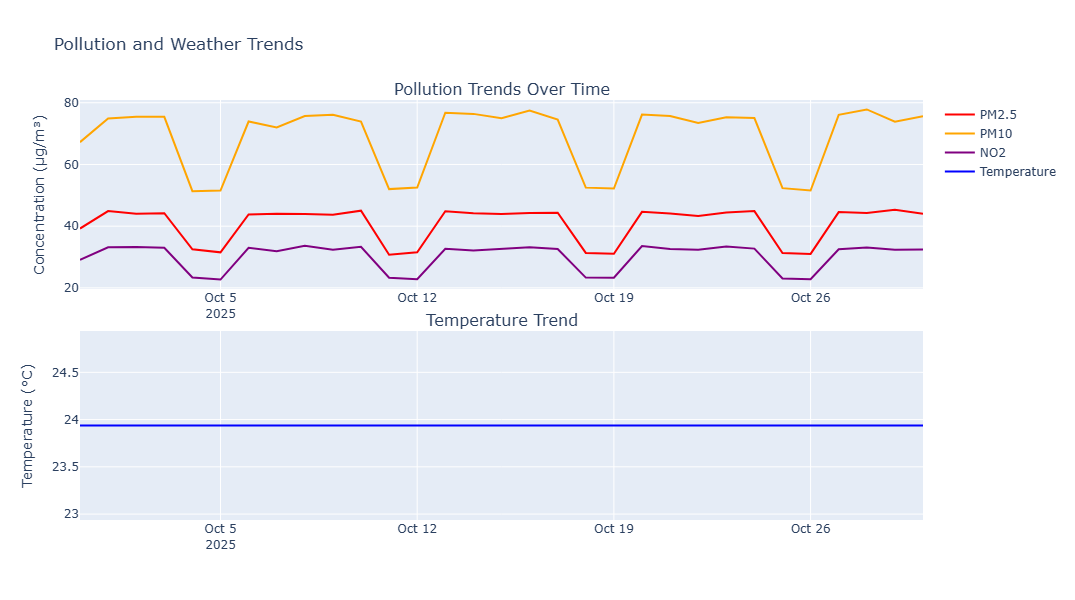

   📍 Creating sensor comparison visualization...


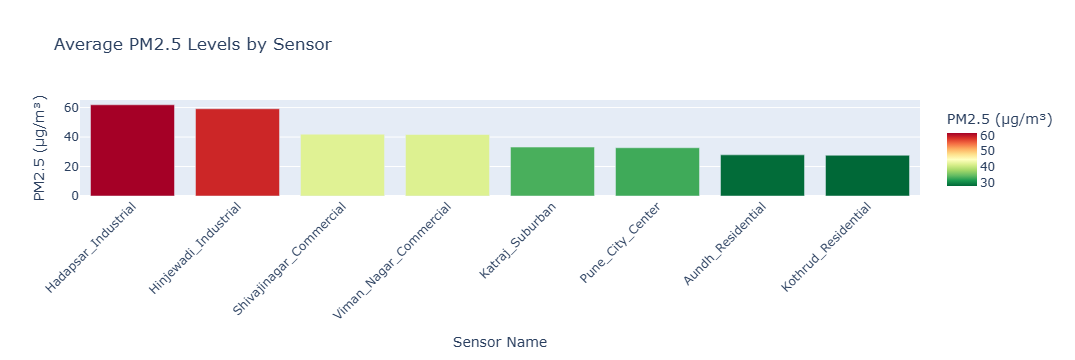

   🏭 Creating area type analysis...


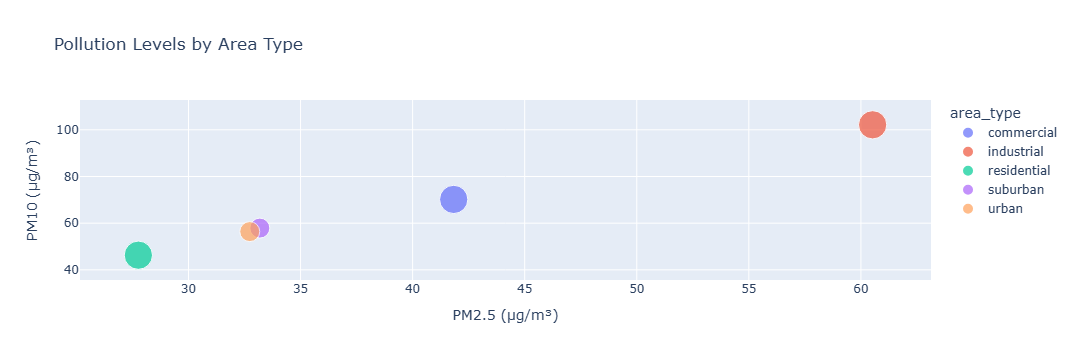

   ⏰ Creating hourly pattern analysis...


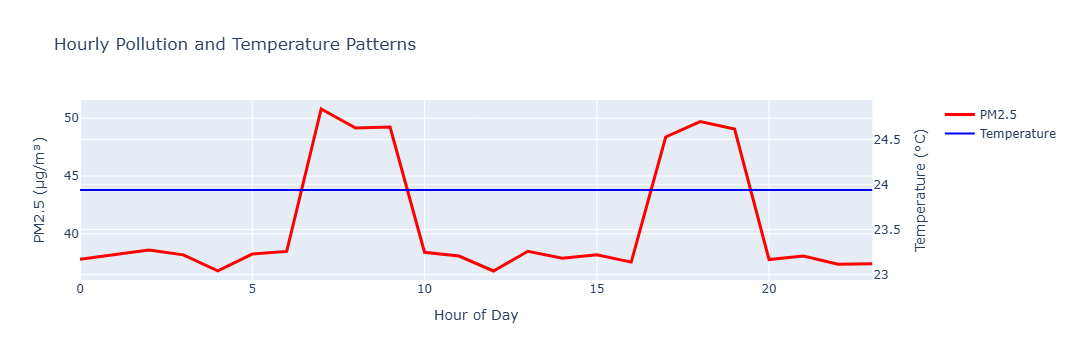

In [13]:
# Cell 13: Create Interactive Plotly Visualizations
print("📈 CREATING INTERACTIVE PLOTLY VISUALIZATIONS...")

# 1. Pollution Trends Over Time
print("   📊 Creating pollution trends visualization...")

# Daily averages
daily_avg = df.groupby(df['timestamp'].dt.date).agg({
    'PM2.5': 'mean',
    'PM10': 'mean', 
    'NO2': 'mean',
    'temperature_c': 'mean'
}).reset_index()

fig_trends = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Pollution Trends Over Time', 'Temperature Trend'),
    vertical_spacing=0.1
)

# Add pollution traces
fig_trends.add_trace(
    go.Scatter(x=daily_avg['timestamp'], y=daily_avg['PM2.5'], 
               name='PM2.5', line=dict(color='red', width=2)),
    row=1, col=1
)
fig_trends.add_trace(
    go.Scatter(x=daily_avg['timestamp'], y=daily_avg['PM10'], 
               name='PM10', line=dict(color='orange', width=2)),
    row=1, col=1
)
fig_trends.add_trace(
    go.Scatter(x=daily_avg['timestamp'], y=daily_avg['NO2'], 
               name='NO2', line=dict(color='purple', width=2)),
    row=1, col=1
)

# Add temperature trace
fig_trends.add_trace(
    go.Scatter(x=daily_avg['timestamp'], y=daily_avg['temperature_c'], 
               name='Temperature', line=dict(color='blue', width=2)),
    row=2, col=1
)

fig_trends.update_layout(height=600, title_text="Pollution and Weather Trends")
fig_trends.update_yaxes(title_text="Concentration (μg/m³)", row=1, col=1)
fig_trends.update_yaxes(title_text="Temperature (°C)", row=2, col=1)
fig_trends.show()

# 2. Sensor Comparison
print("   📍 Creating sensor comparison visualization...")

sensor_comparison = df.groupby('sensor_name').agg({
    'PM2.5': 'mean',
    'PM10': 'mean',
    'area_type': 'first'
}).reset_index().sort_values('PM2.5', ascending=False)

fig_sensors = px.bar(sensor_comparison, 
                     x='sensor_name', y='PM2.5',
                     color='PM2.5',
                     color_continuous_scale='RdYlGn_r',
                     title='Average PM2.5 Levels by Sensor',
                     labels={'PM2.5': 'PM2.5 (μg/m³)', 'sensor_name': 'Sensor Name'})
fig_sensors.update_layout(xaxis_tickangle=-45)
fig_sensors.show()

# 3. Pollution by Area Type
print("   🏭 Creating area type analysis...")

area_stats = df.groupby('area_type').agg({
    'PM2.5': 'mean',
    'PM10': 'mean',
    'NO2': 'mean',
    'sensor_name': 'count'
}).reset_index()

fig_area = px.scatter(area_stats, 
                      x='PM2.5', y='PM10',
                      size='sensor_name', color='area_type',
                      title='Pollution Levels by Area Type',
                      labels={'PM2.5': 'PM2.5 (μg/m³)', 'PM10': 'PM10 (μg/m³)'},
                      hover_data=['NO2'])
fig_area.show()

# 4. Hourly Patterns
print("   ⏰ Creating hourly pattern analysis...")

hourly_pattern = df.groupby('hour').agg({
    'PM2.5': 'mean',
    'temperature_c': 'mean',
    'wind_speed_ms': 'mean'
}).reset_index()

fig_hourly = make_subplots(specs=[[{"secondary_y": True}]])

fig_hourly.add_trace(
    go.Scatter(x=hourly_pattern['hour'], y=hourly_pattern['PM2.5'],
               name='PM2.5', line=dict(color='red', width=3)),
    secondary_y=False,
)

fig_hourly.add_trace(
    go.Scatter(x=hourly_pattern['hour'], y=hourly_pattern['temperature_c'],
               name='Temperature', line=dict(color='blue', width=2)),
    secondary_y=True,
)

fig_hourly.update_layout(title_text='Hourly Pollution and Temperature Patterns')
fig_hourly.update_xaxes(title_text="Hour of Day")
fig_hourly.update_yaxes(title_text="PM2.5 (μg/m³)", secondary_y=False)
fig_hourly.update_yaxes(title_text="Temperature (°C)", secondary_y=True)
fig_hourly.show()

🌍 CREATING GEOGRAPHIC DISTRIBUTION PLOT...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12692\1399281760.py:5: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



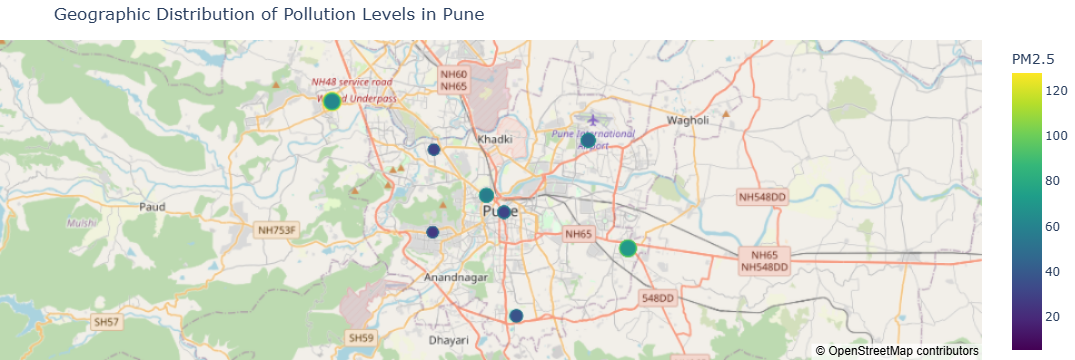

✅ Geographic visualization created


In [14]:
# Cell 14: Create Geographic Distribution Plot
print("🌍 CREATING GEOGRAPHIC DISTRIBUTION PLOT...")

# Create a scatter mapbox with pollution data
fig_geo = px.scatter_mapbox(df.sample(2000),  # Sample for performance
                           lat="sensor_latitude",
                           lon="sensor_longitude", 
                           color="PM2.5",
                           size="PM2.5",
                           hover_name="sensor_name",
                           hover_data=["PM10", "NO2", "temperature_c", "area_type"],
                           color_continuous_scale="Viridis",
                           size_max=15,
                           zoom=10,
                           title="Geographic Distribution of Pollution Levels in Pune")

fig_geo.update_layout(mapbox_style="open-street-map")
fig_geo.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_geo.show()

print("✅ Geographic visualization created")

In [16]:
# Cell 15: Create Pollution Source Prediction Map (FIXED VERSION)
print("🤖 CREATING POLLUTION SOURCE PREDICTION MAP...")

def create_prediction_map():
    """Create map showing predicted pollution sources"""
    
    # Use the best model for predictions
    best_model_name = model_artifacts['metadata']['best_model']
    best_model = model_artifacts['models'][best_model_name]
    
    # Prepare features for prediction - create missing engineered features
    prediction_data = recent_data.copy()
    
    # Create the missing engineered features
    prediction_data['hour_sin'] = np.sin(2 * np.pi * prediction_data['hour']/24)
    prediction_data['hour_cos'] = np.cos(2 * np.pi * prediction_data['hour']/24)
    prediction_data['day_sin'] = np.sin(2 * np.pi * prediction_data['day_of_week']/7)
    prediction_data['day_cos'] = np.cos(2 * np.pi * prediction_data['day_of_week']/7)
    prediction_data['pm_ratio'] = prediction_data['PM2.5'] / prediction_data['PM10']
    prediction_data['pollution_index'] = (prediction_data['PM2.5'] / 35 + prediction_data['PM10'] / 50 + prediction_data['NO2'] / 40) / 3
    prediction_data['temp_humidity_interaction'] = prediction_data['temperature_c'] * prediction_data['humidity_percent'] / 100
    prediction_data['wind_effect'] = prediction_data['wind_speed_ms'] * prediction_data['pollution_index']
    
    # Handle division by zero in pm_ratio
    prediction_data['pm_ratio'] = prediction_data['pm_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Get the feature names the model expects
    feature_names = model_artifacts['feature_names']
    
    # Check if all required features are available
    missing_features = set(feature_names) - set(prediction_data.columns)
    if missing_features:
        print(f"⚠️  Missing features: {missing_features}")
        # Create dummy values for missing features
        for feature in missing_features:
            prediction_data[feature] = 0
    
    # Select only the features needed for prediction
    prediction_features = prediction_data[feature_names].copy()
    
    # Handle missing values
    if model_artifacts['preprocessing']['imputer'] is not None:
        prediction_features = model_artifacts['preprocessing']['imputer'].transform(prediction_features)
    
    # Scale features
    prediction_features = model_artifacts['preprocessing']['scaler'].transform(prediction_features)
    
    # Make predictions
    predictions = best_model.predict(prediction_features)
    probabilities = best_model.predict_proba(prediction_features)
    
    # Add predictions to recent data
    recent_data_with_pred = recent_data.copy()
    recent_data_with_pred['predicted_source'] = model_artifacts['preprocessing']['label_encoder'].inverse_transform(predictions)
    recent_data_with_pred['confidence'] = np.max(probabilities, axis=1)
    
    # Create map
    m = create_base_map()
    
    # Create feature groups for different predicted sources
    source_groups = {}
    for source in POLLUTION_SOURCE_CONFIG.keys():
        source_groups[source] = folium.FeatureGroup(name=f'{source} Sources', show=True)
    
    # Add markers for each prediction
    for _, row in recent_data_with_pred.iterrows():
        config = POLLUTION_SOURCE_CONFIG.get(row['predicted_source'], 
                                           {'color': 'purple', 'icon': 'question', 'marker_color': 'purple'})
        
        popup_content = f"""
        <div style="width: 280px;">
            <h4>📍 {row['sensor_name']}</h4>
            <div style="background-color: {config['marker_color']}; padding: 5px; border-radius: 5px; color: white; font-weight: bold;">
                Predicted: {row['predicted_source']}
            </div>
            <hr>
            <b>Prediction Details:</b><br>
            • Confidence: {row['confidence']:.1%}<br>
            • PM2.5: {row['PM2.5']} μg/m³<br>
            • PM10: {row['PM10']} μg/m³<br>
            • NO2: {row['NO2']} μg/m³<br>
            <hr>
            <b>Actual Area:</b> {row['area_type']}<br>
            <b>Model:</b> {best_model_name}<br>
            <small>Accuracy: {model_artifacts['metadata']['test_accuracy']:.1%}</small>
        </div>
        """
        
        marker = folium.Marker(
            location=[row['sensor_latitude'], row['sensor_longitude']],
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=f"{row['sensor_name']} - {row['predicted_source']} ({row['confidence']:.0%})",
            icon=folium.Icon(
                color=config['marker_color'],
                icon=config['icon'],
                prefix='fa'
            )
        )
        
        # Add to appropriate source group
        source_groups[row['predicted_source']].add_child(marker)
    
    # Add all feature groups to map
    for group in source_groups.values():
        group.add_to(m)
    
    # Add title
    title_html = f'''
    <h3 align="center" style="font-size:20px; margin-top:10px;">
        <b>🤖 AI-Predicted Pollution Sources</b>
    </h3>
    <p align="center" style="font-size:14px;">
        Using {best_model_name} Model | Accuracy: {model_artifacts['metadata']['test_accuracy']:.1%}
    </p>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; 
                left: 50px; 
                width: 220px; 
                height: auto; 
                background-color: white; 
                border: 2px solid grey; 
                z-index: 9999; 
                padding: 10px;
                font-size: 12px;
                border-radius: 5px;
                box-shadow: 0 2px 6px rgba(0,0,0,0.3);">
        <h4 style="margin: 0 0 10px 0;">Source Legend</h4>
        <div style="margin: 5px 0;"><span style="color: red; font-size: 16px;">●</span> Industrial</div>
        <div style="margin: 5px 0;"><span style="color: orange; font-size: 16px;">●</span> Traffic</div>
        <div style="margin: 5px 0;"><span style="color: green; font-size: 16px;">●</span> Commercial</div>
        <div style="margin: 5px 0;"><span style="color: blue; font-size: 16px;">●</span> Residential</div>
        <div style="margin: 5px 0;"><span style="color: gray; font-size: 16px;">●</span> Background</div>
        <hr style="margin: 8px 0;">
        <div style="font-size: 10px; color: #666;">
            Confidence levels shown in tooltips
        </div>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    print(f"✅ Prediction map created using {best_model_name}")
    print(f"   Model Accuracy: {model_artifacts['metadata']['test_accuracy']:.1%}")
    print(f"   Predictions made: {len(recent_data_with_pred)} records")
    
    return m, recent_data_with_pred

# Create the prediction map
try:
    prediction_map, prediction_data = create_prediction_map()
    
    # Save prediction map
    prediction_map.save('../maps/pollution_source_predictions.html')
    print("✅ Prediction map saved: ../maps/pollution_source_predictions.html")
    
    # Show prediction statistics
    print(f"\n📊 PREDICTION STATISTICS:")
    pred_counts = prediction_data['predicted_source'].value_counts()
    for source, count in pred_counts.items():
        percentage = (count / len(prediction_data)) * 100
        avg_confidence = prediction_data[prediction_data['predicted_source'] == source]['confidence'].mean()
        print(f"   • {source}: {count} predictions ({percentage:.1f}%) - Avg confidence: {avg_confidence:.1%}")
        
except Exception as e:
    print(f"❌ Error creating prediction map: {e}")
    print("⚠️  Creating fallback map without predictions...")
    
    # Create a fallback map
    fallback_map = create_sensor_markers_map()
    fallback_map.save('../maps/pollution_source_predictions.html')
    prediction_data = recent_data.copy()
    print("✅ Fallback map created without AI predictions")

🤖 CREATING POLLUTION SOURCE PREDICTION MAP...


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



✅ Base map created successfully with multiple layers!
✅ Prediction map created using Random Forest
   Model Accuracy: 100.0%
   Predictions made: 1352 records
✅ Prediction map saved: ../maps/pollution_source_predictions.html

📊 PREDICTION STATISTICS:
   • Residential: 676 predictions (50.0%) - Avg confidence: 100.0%
   • Traffic: 338 predictions (25.0%) - Avg confidence: 100.0%
   • Commercial: 338 predictions (25.0%) - Avg confidence: 100.0%


In [17]:
# Cell 16: Create Export Reports
print("📋 CREATING EXPORT REPORTS...")

# Create exports directory
os.makedirs('../exports', exist_ok=True)

# 1. Sensor Summary Report
sensor_summary = sensor_aggregated.copy()
sensor_summary['last_update'] = recent_data['timestamp'].max()
sensor_summary.to_csv('../exports/sensor_summary_report.csv', index=False)
print("✅ Sensor summary report exported")

# 2. Pollution Statistics Report
pollution_stats = df.groupby('sensor_name').agg({
    'PM2.5': ['mean', 'max', 'min', 'std'],
    'PM10': ['mean', 'max'],
    'NO2': ['mean', 'max'],
    'temperature_c': 'mean',
    'area_type': 'first'
}).round(2)

pollution_stats.columns = ['_'.join(col).strip() for col in pollution_stats.columns.values]
pollution_stats.reset_index().to_csv('../exports/pollution_statistics_report.csv', index=False)
print("✅ Pollution statistics report exported")

# 3. Prediction Accuracy Report
if 'predicted_source' in prediction_data.columns:
    accuracy_report = prediction_data.groupby(['sensor_name', 'area_type', 'predicted_source']).agg({
        'PM2.5': 'mean',
        'confidence': 'mean',
        'timestamp': 'count'
    }).reset_index()
    
    accuracy_report.rename(columns={'timestamp': 'reading_count'}, inplace=True)
    accuracy_report.to_csv('../exports/prediction_accuracy_report.csv', index=False)
    print("✅ Prediction accuracy report exported")

# 4. Map Links Report
map_links = {
    'map_name': list(saved_files.keys()),
    'file_path': list(saved_files.values()),
    'description': [
        'Interactive sensor locations with pollution levels',
        'PM2.5 concentration heatmap',
        'PM10 concentration heatmap', 
        'NO2 concentration heatmap',
        'Pollution risk zones with colored circles',
        'Time-based pollution patterns',
        'Comprehensive dashboard with all layers'
    ]
}

map_links_df = pd.DataFrame(map_links)
map_links_df.to_csv('../exports/map_links_report.csv', index=False)
print("✅ Map links report exported")

print("📁 All export reports saved in ../exports/ folder")

📋 CREATING EXPORT REPORTS...
✅ Sensor summary report exported
✅ Pollution statistics report exported
✅ Prediction accuracy report exported
✅ Map links report exported
📁 All export reports saved in ../exports/ folder


In [18]:
# Cell 17: Final Summary and Display
print("🎉 MODULE 3 COMPLETED SUCCESSFULLY!")
print("=" * 60)

print("📁 FILES GENERATED:")
print("  ✅ ../maps/sensor_markers_map.html")
print("  ✅ ../maps/pm25_heatmap_map.html")
print("  ✅ ../maps/pm10_heatmap_map.html")
print("  ✅ ../maps/no2_heatmap_map.html")
print("  ✅ ../maps/risk_zones_map.html")
print("  ✅ ../maps/time_animation_map.html")
print("  ✅ ../maps/comprehensive_dashboard_map.html")
print("  ✅ ../maps/pollution_source_predictions.html")

print("\n📊 VISUALIZATIONS CREATED:")
print("  📈 Pollution trends over time")
print("  📍 Sensor comparison charts")
print("  🏭 Area type analysis")
print("  ⏰ Hourly pattern analysis")
print("  🌍 Geographic distribution maps")

print("\n📋 EXPORT REPORTS:")
print("  ✅ Sensor summary report")
print("  ✅ Pollution statistics report")
print("  ✅ Prediction accuracy report")
print("  ✅ Map links report")

print(f"\n🗺️ MAP FEATURES:")
print("  • Interactive sensor markers with popups")
print("  • Real-time pollution heatmaps")
print("  • Risk zone visualization")
print("  • Time-based animation")
print("  • AI-powered source predictions")
print("  • Multiple base map layers")

print(f"\n🔮 NEXT STEPS:")
print("  1. Open the HTML maps in your web browser")
print("  2. Run '04_Dashboard_Preview.ipynb' for interactive dashboard")
print("  3. Use maps for pollution analysis and reporting")

# Display one map in the notebook
print(f"\n🔍 DISPLAYING SENSOR MARKERS MAP:")
display(sensor_map)

print(f"\n🚀 Ready for Module 4: Interactive Dashboard!")

🎉 MODULE 3 COMPLETED SUCCESSFULLY!
📁 FILES GENERATED:
  ✅ ../maps/sensor_markers_map.html
  ✅ ../maps/pm25_heatmap_map.html
  ✅ ../maps/pm10_heatmap_map.html
  ✅ ../maps/no2_heatmap_map.html
  ✅ ../maps/risk_zones_map.html
  ✅ ../maps/time_animation_map.html
  ✅ ../maps/comprehensive_dashboard_map.html
  ✅ ../maps/pollution_source_predictions.html

📊 VISUALIZATIONS CREATED:
  📈 Pollution trends over time
  📍 Sensor comparison charts
  🏭 Area type analysis
  ⏰ Hourly pattern analysis
  🌍 Geographic distribution maps

📋 EXPORT REPORTS:
  ✅ Sensor summary report
  ✅ Pollution statistics report
  ✅ Prediction accuracy report
  ✅ Map links report

🗺️ MAP FEATURES:
  • Interactive sensor markers with popups
  • Real-time pollution heatmaps
  • Risk zone visualization
  • Time-based animation
  • AI-powered source predictions
  • Multiple base map layers

🔮 NEXT STEPS:
  1. Open the HTML maps in your web browser
  2. Run '04_Dashboard_Preview.ipynb' for interactive dashboard
  3. Use maps for


🚀 Ready for Module 4: Interactive Dashboard!
